In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### Структура ноутбука: 
### 1) Загрузка данных 
### 2) Функции обработки исходных датафреймов, генерация новых фичей
### 3) Обработка данных
### 4) Разделение данных на группы
### 5) Обучение модели логистической регресии, вывод ROC_AUC на валидации
### 6) Наблюдения, которые помогли при решении задачи
### 7) Какие идеи не оправдали себя (кратко)


<div align="center">

### Пункт 1. Загрузка данных

</div>

In [ ]:
df_webstat = pd.read_csv("data/t1_webstat.csv")
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

<div align="center">

### Пункт 2. Функции обработки исходных датафреймов, генерации новых фичей
</div>
Новые фичи добавляются в df_train/df_test c помощью left join из df_webstat в агрегированном виде, для каждого уникального order_id. Генерация фич на основе различных признаков разделена в различные функции, чтобы было проще ориентироваться. Функция build_features_pipeline() вызывает внутри себя все функции создания новых фичей. 

In [3]:
def get_df_info(df, thr=0.7, *args, **kwargs):
    '''
    Выводит инфу о колонках датафрейма в виде датафрейма

    df: исходный датафрейм
    thr: пороговое значение для vc_max_ratio, влияет на расчет trash_score
    ...

    returns: pd.DataFrame с инфой
    '''
    
    df_info = pd.DataFrame(index=df.columns)

    df_info['dtype'] = pd.Series(
        [df[col].dtype.name for col in df.columns], 
        index=df.columns
    )

    df_info['nunique'] = pd.Series(
        [df[col].nunique(dropna=False) for col in df.columns],
        index=df.columns
    )

    def count_zero_ratio(df):
        return (df == 0).sum() / len(df)

    df_info['zero_ratio'] = pd.Series(
        ["-1" if (df[col] == 0).sum() == 0
        else f"z :{count_zero_ratio(df[col]):.3f}"
        for col in df.columns], 
        index=df.columns
    )

    def count_nan_ratio(df):
        return df.isna().sum() / len(df)

    df_info['nan_ratio'] = pd.Series(
        ["-1" if df[col].isna().sum() == 0
        else f"n: {count_nan_ratio(df[col]):.3f}"
        for col in df.columns],
        index=df.columns
    )

    def count_empty_ratio(df):
        return (df == '').sum() / len(df)

    df_info['empty_ratio'] = pd.Series(
        ["-1" if (df[col] == '').sum() == 0
        else f"e: {count_empty_ratio(df[col]):.3f}"
        for col in df.columns], 
        index=df.columns
    )

    def count_vc_max(df):
        value = df.value_counts(dropna=True).index[0]
        count = df.value_counts(dropna=True).iloc[0]
        ratio = count / len(df)
        return value, count, ratio

    df_info["vc_max"] = pd.Series(
        ["-1" if df[col].value_counts(dropna=True).empty
        else f"({count_vc_max(df[col])[2]:.3f}, {count_vc_max(df[col])[0]})"
        for col in df.columns],
        index=df.columns
    )

    df_info["example_1"] = pd.Series(
        [df[col].dropna().unique()[0] 
        if len(df[col].dropna().unique()) > 0 
        else "no example"
        for col in df.columns], 
        index=df.columns
    )
    df_info.loc[df_info['example_1'] == '','example_1'] = 'e:'

    df_info["example_2"] = pd.Series(
        [df[col].dropna().unique()[-1] 
        if len(df[col].dropna().unique()) > 0 and df[col].dropna().unique()[-1] != df[col].dropna().unique()[0]
        else "no example"
        for col in df.columns], 
        index=df.columns
    )
    df_info.loc[df_info['example_2'] == '', 'example_2'] = 'e:'

    def count_trash_score(df, col):
        a = 0
        a += count_nan_ratio(df) if df_info.loc[col, 'nan_ratio'] != "-1" else 0
        a += count_zero_ratio(df) if df_info.loc[col, 'zero_ratio'] != "-1" else 0
        a += count_empty_ratio(df) if df_info.loc[col, 'empty_ratio'] != "-1" else 0
        vc_max_ratio = count_vc_max(df)[2] if df_info.loc[col, 'vc_max'] != "-1" else 0
        b = vc_max_ratio if vc_max_ratio > thr else 0
        return max(a, b)
        
    df_info['trash_score'] = pd.Series(
        [f"{count_trash_score(df[col], col):.3f}"
        if count_trash_score(df[col], col) != 0
        else "-1"
        for col in df.columns], 
        index=df.columns
    )

    return df_info

In [4]:
def webstat_preprocessing(df_webstat):
    '''
    заменяет нулевые и отрицательные значения  df_webstat['pageview_duration_sec'] на среднее, приводит к формату datetime df_webstat['date_time']
    df_webstat: pd.DataFrame 

    returns df_wesbstat с новыми фичами
    '''

    df_webstat.sort_values('date_time', inplace=True)
    df_webstat.date_time = pd.to_datetime(df_webstat.date_time, errors='raise')

    mean_value = df_webstat.loc[
        (df_webstat['pageview_duration_sec'].notna()) &
        (df_webstat['pageview_duration_sec'] >= 0),
        'pageview_duration_sec'
    ].mean()

    df_webstat.loc[
        (df_webstat['pageview_duration_sec'].isna()) |
        (df_webstat['pageview_duration_sec'] < 0),
        'pageview_duration_sec'
    ] = mean_value

    return df_webstat

In [5]:
def generate_time_features(df_train, df_webstat):
    '''
    Добавляет временные числовые фичи в df_train, приводит df_train['date_time'] к типу pd.datetime

    df_train: pd.Dataframe (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_train с новыми фичами 
    '''

    df_train.create_time = pd.to_datetime(df_train.create_time, errors='raise')

    session_start = (
    df_webstat
    .groupby('sessionkey_id')['date_time']
    .min()
    .reset_index(name='session_start_time')
    )

    session_end = (
    df_webstat
    .groupby('sessionkey_id')['date_time']
    .max()
    .reset_index(name='session_end_time')
    )


    merged = (
        df_train
        .merge(session_start, on='sessionkey_id', how='left')
        .merge(session_end, on='sessionkey_id', how='left')
    )

    # разница времени создания заказа и начала сессии
    merged['time_diff_create_start'] = (merged['create_time'] - merged['session_start_time']).dt.total_seconds() / 60

    # разница времени создания заказа и конца сессии
    merged['time_diff_create_end'] = (merged['create_time'] - merged['session_end_time']).dt.total_seconds() / 60

    # разница времени начала и конца сессии
    merged['time_diff_start_end'] = (merged['session_end_time'] - merged['session_start_time']).dt.total_seconds() / 60

    # где находится время создания заказа относительно времени конца сессии
    merged['create_position_ratio'] = (
    merged['time_diff_create_start'] /
    merged['time_diff_start_end'].replace(0, np.nan)
    )

    merged = merged.drop(columns=['session_start_time', 'session_end_time'])

    return merged

In [6]:
def generate_page_features(df_train, df_webstat):
    '''
    Добавляет числовые фичи основываясь на столбцах 'pageview_number', 'page_type', 'pageview_duration_sec' из df_webstat

    df_train: pd.DataFrame (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_train c новыми фичами 
    '''
    # сколько всего просмотров страниц было для этой сессии
    pageview_amount = (
        df_webstat
        .groupby('sessionkey_id')['pageview_number']
        .max()
        .reset_index(name='pageview_amount')
    )

    # сколько различных типов страниц просмотрено внутри сессии
    unique_pagetype_amount =(
        df_webstat
        .groupby('sessionkey_id')['page_type']
        .nunique()
        .reset_index(name='unique_pagetype_amount')
    )

    # сколько раз в сессии пользователь был на каждом типе станиц
    page_type_counts = (
        df_webstat
        .groupby(['sessionkey_id', 'page_type'])
        .size()
        .unstack(fill_value=0)
    )
    page_type_counts = page_type_counts.add_prefix('page_type_').reset_index()

    # последняя станица в сессии
    last_page_type = (
        df_webstat
        .sort_values(['sessionkey_id', 'pageview_number'])
        .groupby('sessionkey_id')
        .tail(1)[['sessionkey_id', 'page_type']]
        .rename(columns={'page_type': 'last_page_type'})
        .reset_index(drop=True)
    )

    # среднее время просмотра одной страницы внутри сессии
    pageview_duration_av = (
        df_webstat
        .groupby('sessionkey_id')['pageview_duration_sec']
        .mean()
        .reset_index(name='pageview_duration_av')
    )

    # стандартное отклонение времени просмотра одной страницы внутри сессии
    pageview_duration_std = (
        df_webstat
        .groupby('sessionkey_id')['pageview_duration_sec']
        .std()
        .reset_index(name='pageview_duration_std')
    )

    # суммарное время предывания на страницах
    pageview_duration_sum = (
        df_webstat
        .groupby('sessionkey_id')['pageview_duration_sec']
        .sum()
        .reset_index(name='pageview_duration_sum')
    )

    # средняя длительность пребывания на каждого типа странице
    page_type_duration_mean = (
        df_webstat
        .groupby(['sessionkey_id', 'page_type'])['pageview_duration_sec']
        .mean()
        .unstack(fill_value=0)
    )
    page_type_duration_mean = (
        page_type_duration_mean
        .add_prefix('page_type_dur_')
        .reset_index()
    )

    # как часто пользователь вернулся на уже посещенный тип страницы
    returns_ratio = (
    df_webstat
    .groupby('sessionkey_id')['page_type']
    .apply(lambda x: 1 - len(set(x)) / len(x))
    .reset_index(name='page_type_repeat_ratio')
    )

    # средний интервал между пребыванием на страницах
    avg_inter_page_time = (
    df_webstat
    .sort_values(['sessionkey_id', 'date_time'])
    .groupby('sessionkey_id')['date_time']
    .apply(lambda x: x.diff().dt.total_seconds().mean())
    .reset_index(name='avg_inter_page_time')
    )

    # статистики по временам между страницами
    df_webstat['inter_page_sec'] = (
        df_webstat
        .groupby('sessionkey_id')['date_time']
        .diff()
        .dt.total_seconds()
    )
    inter_page_times = (
        df_webstat
        .groupby('sessionkey_id')['inter_page_sec']
        .agg(
            avg_page_interval='mean',
            std_page_interval='std',
            max_page_interval='max',
            min_page_interval='min',
        )
        .reset_index()
    )

    # время суток сессии
    df_webstat['hour'] = pd.to_datetime(df_webstat['date_time']).dt.hour
    session_hour = (
    df_webstat
    .groupby('sessionkey_id')['hour']
    .mean()
    .reset_index(name='avg_session_hour')
    )

    # средний день недели
    df_webstat['weekday'] = pd.to_datetime(df_webstat['date_time']).dt.weekday
    session_weekday = (
    df_webstat
    .groupby('sessionkey_id')['weekday']
    .mean()
    .reset_index(name='avg_session_weekday')
    )

    # сколько раз страница посещена / суммарное число посещенных страниц внутри данной сессии
    page_type_ratios = (
        page_type_counts
        .merge(pageview_amount, on='sessionkey_id', how='left')
    )
    ratio_cols = []
    for col in page_type_counts.columns:
        if col == 'sessionkey_id':
            continue
        ratio_col = col.replace('page_type_', 'page_type_ratio_')
        page_type_ratios[ratio_col] = (
            page_type_ratios[col] / page_type_ratios['pageview_amount']
        )
        ratio_cols.append(ratio_col)
    page_type_ratios = page_type_ratios[['sessionkey_id'] + ratio_cols]

    merged = (
        df_train
        .merge(pageview_amount, on='sessionkey_id', how='left')
        .merge(unique_pagetype_amount, on='sessionkey_id', how='left')
        .merge(page_type_counts, on='sessionkey_id', how='left')
        .merge(last_page_type, on='sessionkey_id', how='left')
        .merge(pageview_duration_av, on='sessionkey_id', how='left')
        .merge(pageview_duration_std, on='sessionkey_id', how='left')
        .merge(pageview_duration_sum, on='sessionkey_id', how='left')
        .merge(page_type_duration_mean, on='sessionkey_id', how='left')
        .merge(returns_ratio, on='sessionkey_id', how='left')
        .merge(avg_inter_page_time, on='sessionkey_id', how='left')
        .merge(session_hour, on='sessionkey_id', how='left')
        .merge(session_weekday, on='sessionkey_id', how='left')
        .merge(inter_page_times, on='sessionkey_id', how='left')
        .merge(page_type_ratios, on='sessionkey_id', how='left')
    )

    return merged

In [7]:
def generate_category_features(df_train, df_webstat):
    '''
    Добавляет новую фичу основыываясь на том, является ли последняя category_id внутри данной сесси nan или нет

    df_train: pd.Dataframe (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_train с новыми фичами
    '''
    # находим индекс последней по времени строки в каждой сессии
    last_idx = (
        df_webstat
        .groupby('sessionkey_id')['date_time']
        .idxmax()
    )

    last_rows = (
        df_webstat
        .loc[last_idx, ['sessionkey_id', 'category_id']]
        .reset_index(drop=True)
    )

    last_rows['last_category_is_nan'] = last_rows['category_id'].isna().map({True: 1, False: 2})
    last_rows = last_rows[['sessionkey_id', 'last_category_is_nan']]

    merged = (
        df_train
        .merge(last_rows, on='sessionkey_id', how='left')
    )

    return merged

In [8]:
def generate_train_features(df_train):
    '''
    добавляет новую фичу - номер заказа внутри данной сессии

    df_train: pd.Dataframe (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_train с новой фичой
    '''

    df_sorted = (
        df_train
        .sort_values(['sessionkey_id', 'create_time'])
        .reset_index(drop=False)
    )

    df_sorted['order_num'] = (
        df_sorted
        .groupby('sessionkey_id')
        .cumcount() + 1
    )

    merged = (
        df_sorted
        .sort_values('index')
        .drop(columns=['index'])
        .reset_index(drop=True)
    )

    return merged

In [9]:
def drop_features(df_train):
    """
    Удаляет из df_train указанные неиспользуемые столбцы

    df_train: pd.Dataframe (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_train c удаленными ненужными столбцами
    """

    cols_to_drop = [
        'order_id', 'create_time', 'good_id', 'price', 'utm_medium',
        'utm_source', 'sessionkey_id', 'category_id', 'parent_id', 'root_id',
        'model_id', 'is_moderated', 'rating_value', 'rating_count',
        'description_length', 'goods_qty', 'pics_qty', 'model_create_time'
    ]

    df_train = df_train.drop(columns=cols_to_drop, errors='ignore')

    return df_train

In [10]:
def plot_weights(model, features, top_k=20):
    '''
    Рисует значения весов линейной модели при признаках
    
    top_k: рисовать первые top_k весов по модулю
    '''
    # подготовка необходимого
    num_features_to_plot = min(top_k, len(features))
    weights = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_ # классификация vs регрессия
    sorted_idx = np.argsort(-np.abs(weights))
    bias = model.intercept_[0] if not isinstance(model.intercept_, float) else model.intercept_ # классификация vs регрессия
    
    fig, ax = plt.subplots(figsize=(8, num_features_to_plot / 2))
    
    # сами бары
    container = ax.barh(y=features[sorted_idx][:top_k][::-1], width=weights[sorted_idx][:top_k][::-1])
    
    # приписать к ним значения весов
    ax.bar_label(container, weights[sorted_idx][:top_k][::-1].round(3), color='red', fontsize=15)
    
    # настройка ах'a
    ax.margins(0.2, 0.05)
    ax.set_title('Top-10 feature weights', fontsize=15, pad=10)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('weight', fontsize=15)
    ax.text(0.99, 0.02, f'bias: {bias:.1e}', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=15)
    
    plt.show()

In [11]:
def build_features_pipeline(df_train, df_webstat):
    '''
    Собирает вместе все функции создания новых числовых фичей

    df_train: pd.Dataframe (train.csv / test.csv)
    df_webstat: pd.DataFrame (t1_webstat.csv)

    returns df_webstat c новыми фичами
    '''
    
    df_webstat = webstat_preprocessing(df_webstat)
    df_train = generate_time_features(df_train, df_webstat)
    df_train = generate_page_features(df_train, df_webstat)
    df_train = generate_category_features(df_train, df_webstat)
    df_train = generate_train_features(df_train)

    return df_train

<div align="center">

### Пункт 3. Обработка данных

</div>

In [ ]:
# добавление новых числовых фичей, сохраняем df_train_full, df_test_full, чтобы потом восстановить ответ с order_id
df_train_full = build_features_pipeline(df_train, df_webstat)
df_train = drop_features(df_train_full)
df_test_full = build_features_pipeline(df_test, df_webstat)
df_test = drop_features(df_test_full)

<div align="center">

### Пункт 4. Разделение данных на группы

</div>
Данные разделяются на группы в зависимости от временной фичи 'time_diff_crate_start' - разница между временем создания заказа и временем начала сессии, к которой принадлежит этот заказ (в минутах). Всего 5 групп, с пороговыми значениями, которые указаны в функции assign_time_group. Логика введения такой фичи: пользователи, которые создают закза почти сразу же после того, как они зашли на сайт и пользователи, которые создали заказ через сутки ведут себя по-разному. Они пренадлежат к разным категориям, поэтому будем отдельно обучать логистическую регрессию внутри каждой из этих групп. Пороги для групп выбраны "на глазок" из визуализации (график будет нуже)

In [13]:
def assign_time_group(diff):
    '''
    Вспомогательная функция для разделения данных на 5 групп в зависимости от 
    значения фичи 'time_diff_create_start' в минутах

    diff: число

    returns название группы 'instant', 'short', 'medium', 'long', 'very_long'
    '''
    if diff < 10:
        return 'instant'
    elif diff < 35:
        return 'short'
    elif diff < 120:
        return 'medium'
    elif diff < 600:
        return 'long'
    else:
        return 'very_long'
    
# создание нового категориального признака - группа 'create_time_group'
df_train['create_time_group'] = df_train['time_diff_create_start'].apply(assign_time_group)
df_test['create_time_group'] = df_test['time_diff_create_start'].apply(assign_time_group)

<div align="center">

### Пункт 5. Обучение логистической регрессии, вывод ROC-AUC на валидации. 

</div>

In [14]:
def make_model():
    '''
    Pipeline логистической регрессии с заполнением 
    '''
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=1000,
            penalty='l1',
            solver='liblinear',
            class_weight='balanced',
            C = 1
        ))
    ])


def train_by_time_groups(df_train, df_test=None, group_col='create_time_group', val_frac=0.2):
    """
    Обучает отдельную логистическую регрессию внутри каждой группы 'create_time_group',
    при этом в конце считает одну общую ROC-AUC по всей валидации.

    df_train: датафрейм с числовыми фичами train

    df_test: датафрейм с чиловыми фичами test

    returns:
        models: dict[group_name] -> model
        val_preds: pd.Series с предсказанными вероятностями (по индексам df_train)
        val_targets: pd.Series с таргетом (по индексам df_train)
        global_roc_auc: float
        test_preds: pd.Series (если df_test передан), иначе None
    """

    target_col = 'is_callcenter'

    df_train = df_train.copy()
    if df_test is not None:
        df_test = df_test.copy()

    models = {}

    # валидационные предсказания всех групп
    val_preds = pd.Series(index=df_train.index, dtype=float)
    val_targets = pd.Series(index=df_train.index, dtype=float)

    # обучение по группам
    for group_name, df_grp in df_train.groupby(group_col, sort=False):
        n = len(df_grp)
        split_idx = int(n * (1 - val_frac))

        df_grp_train = df_grp.iloc[:split_idx]
        df_grp_val = df_grp.iloc[split_idx:]

        X_tr = df_grp_train.drop(columns=[target_col, group_col])
        y_tr = df_grp_train[target_col]

        X_val = df_grp_val.drop(columns=[target_col, group_col])
        y_val = df_grp_val[target_col]

        model = make_model()
        model.fit(X_tr, y_tr)
        models[group_name] = model

        # если валидация в группе одноклассная — пропускаем в общей метрике
        if y_val.nunique() < 2:
            continue

        y_val_proba = model.predict_proba(X_val)[:, 1]

        # записываем исходные индексы в правильном порядке
        val_preds.loc[df_grp_val.index] = y_val_proba
        val_targets.loc[df_grp_val.index] = y_val

    # расчет roc_auc на валидации
    mask = val_preds.notna() & val_targets.notna()
    global_roc_auc = roc_auc_score(val_targets[mask], val_preds[mask])

    # предсказания на тесте
    test_preds = None
    if df_test is not None:
        test_preds = pd.Series(index=df_test.index, dtype=float)
        for group_name, df_grp_test in df_test.groupby(group_col, sort=False):
            model = models.get(group_name)
            X_test_grp = df_grp_test.drop(columns=[group_col])
            proba = model.predict_proba(X_test_grp)[:, 1]
            test_preds.loc[df_grp_test.index] = proba

    return models, val_preds, val_targets, global_roc_auc, test_preds

In [15]:
models, val_preds, val_targets, val_auc, test_preds = train_by_time_groups(
    df_train,
    df_test, 
    group_col='create_time_group',
    val_frac=0.2,
)

print("ROC-AUC на всей валидации:", val_auc)

ROC-AUC на всей валидации: 0.9368173110647792


<div align="center">

#### Главные фичи для группы 'instant' (создается заказ в течение не более 10 минут после начала сессии)

</div>

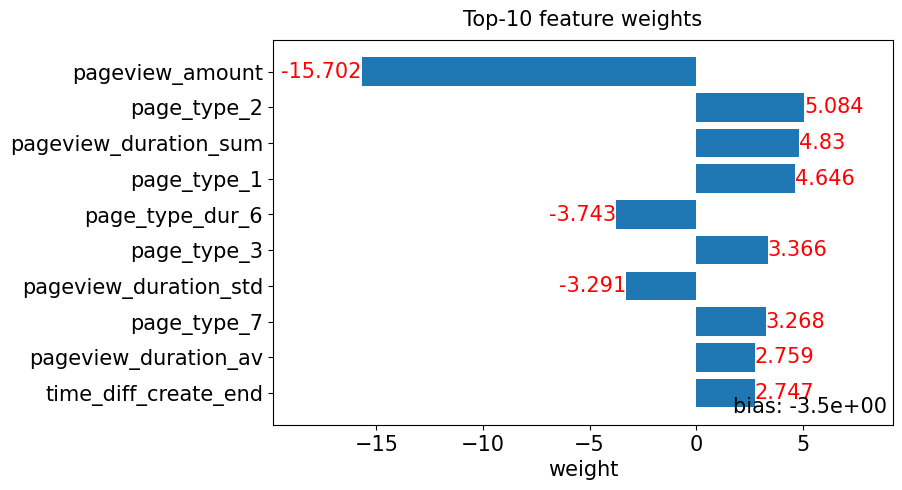

In [16]:
group_name = 'instant'
pipe = models[group_name]
logreg = pipe.named_steps['clf']

feature_names = df_train.drop(columns=['is_callcenter', 'create_time_group']).columns.values

plot_weights(logreg, feature_names, top_k=10)

<div align="center">

#### Главные фичи для группы 'very long' (создается заказ в течение более 10 часов после начала сессии)

</div>

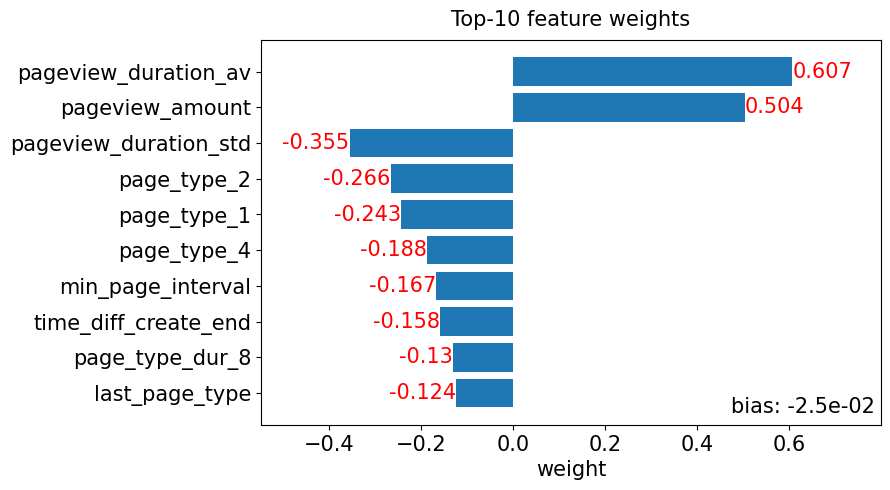

In [17]:
group_name = 'very_long'
pipe = models[group_name]
logreg = pipe.named_steps['clf']

feature_names = df_train.drop(columns=['is_callcenter', 'create_time_group']).columns.values

plot_weights(logreg, feature_names, top_k=10)

<div align="center">

#### Наблюдается совершенно непохожее распределение фичей в двух далеких друг от друга группах, что подтверждает предположение о разумности разделения на группы. Основыне фичи, которые имеют максимальный по модулю вес свзяаны с количеством раз, сколько человек заходил на каждого типа страницу, статистики по длительности пребывания на каждом типе страниц (эти типы различные для двух групп). 

</div>

In [ ]:
# submission = pd.DataFrame({
#     'order_id': df_test_full['order_id'].values,
#     'is_callcenter': test_preds.values,
# })

# submission.to_csv('data/submission_4.csv', index=False)

<div align="center">

### Пункт 6. Наблюдения, которые помогли при решении задачи

</div>

### 1) Внимательное вглядывание в данные, чтобы понять, как соотносятся две df_train, df_webstat. В одной сессии может быть несколько заказов, при этом заказы уникальные, бывают разлинчные смещщения во времени между созданием заказа и началом сессии. 
### 2) Построения baseline для логистической регрессии. При обучени на ~20 фичах, 13 из которых - сколько раз пользователь побывал на каждого типе странице, дале скор ~0.88 на test на kaggle, где основыне веса соответствовали как раз этим 13 фичам. 
###  3) Построение barplot зависимоcти последнего типа страницы 'last_page_type' внутри каждой сессии, влияние этого фактора на то, позвонит пользователь в колцентр или нет. График ниже показывает, что если в сессии страница 6 - последняя, то вероятность звонка очень мала (меньше 5%). При этом, например, если последняя страница 1 или 13, то вероятность звонка в коллцентр больше 50 %. Это навело на мысль, что надо создать побольше фичей, построенных на анализе того, как пользователь перемещается между страницами внутри одной сессии. 

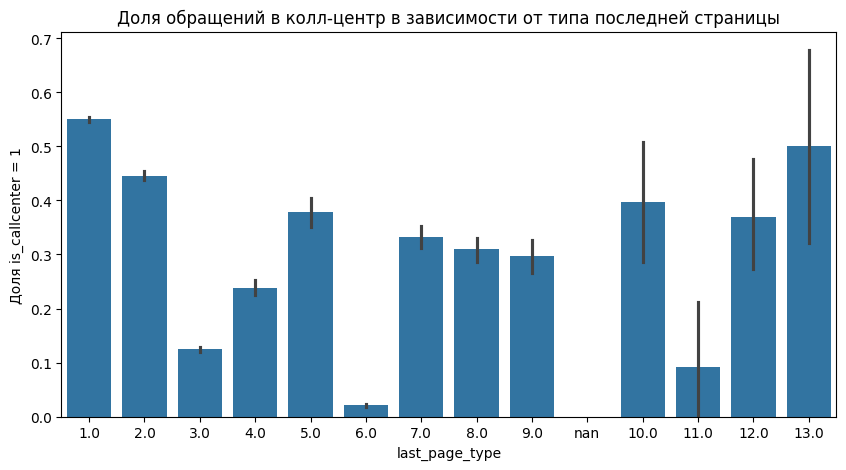

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_train_full,
    x='last_page_type',
    y='is_callcenter',
    order=sorted(df_train_full['last_page_type'].unique())
)
plt.title('Доля обращений в колл-центр в зависимости от типа последней страницы')
plt.ylabel('Доля is_callcenter = 1')
plt.xlabel('last_page_type')
plt.show()

###  4) Построение матрицы вероятности переходов между каждым типом страниц. Чаще всего происходят диагональные переходы (когда человек из типа страницы i переходит на тот же тип страницы). Сложно интерпретируемая матрица, однако, дающая понять, что надо искать где-то рядом с пользовательским поведением по страницам. 

In [21]:
def plot_heatmap_transition(df_train_one):
    df_sorted = df_train_one.sort_values(['sessionkey_id', 'pageview_number'])
    df_sorted['next_page'] = df_sorted.groupby('sessionkey_id')['page_type'].shift(-1)
    df_transitions = df_sorted.dropna(subset=['next_page'])
    transition_counts = (
        df_transitions
        .groupby(['page_type', 'next_page'])
        .size()
        .unstack(fill_value=0)
    )
    transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_probs, cmap='viridis', annot=True, fmt=".3f")
    plt.title("Page Type Transition Probability Matrix")
    plt.xlabel("Next Page Type (j)")
    plt.ylabel("Current Page Type (i)")
    plt.show()

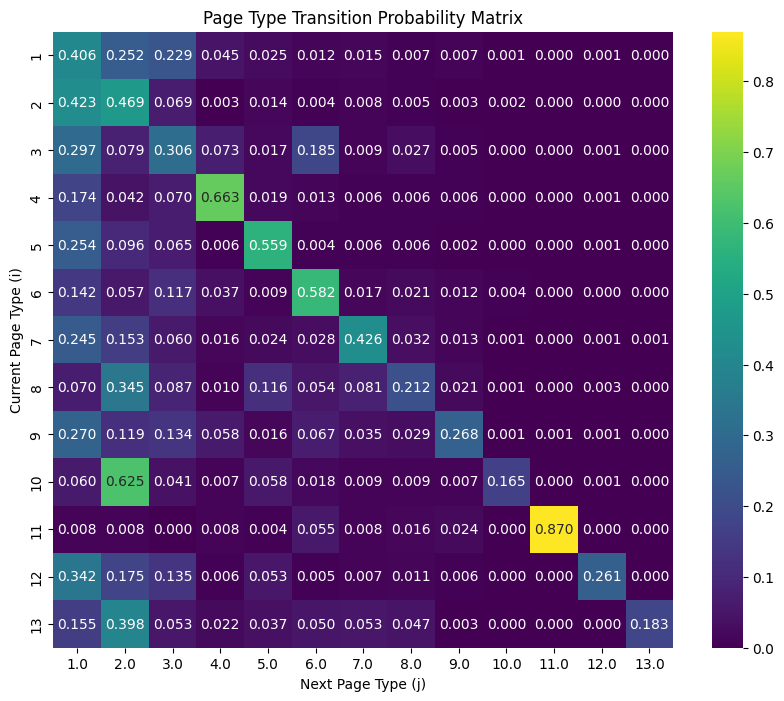

In [37]:
df_webstat_init = pd.read_csv("data/t1_webstat.csv")
df_train_init = pd.read_csv("data/train.csv")
df_train_init.create_time = pd.to_datetime(df_train_init.create_time, errors='raise')
df_webstat_init.sort_values('date_time', inplace=True)
df_webstat_init.date_time = pd.to_datetime(df_webstat_init.date_time, errors='raise')

cols_train = ["create_time", "sessionkey_id", "is_callcenter"]
cols_web   = ["date_time", "page_type", "pageview_number",
              "pageview_duration_sec", "category_id", "sessionkey_id"]

df_train_init = df_webstat[cols_web].merge(
    df_train_init[cols_train],
    on=["sessionkey_id"],
    how="inner",
)

plot_heatmap_transition(df_train_init[df_train_init['is_callcenter'] == 0])

###  5) Построение гистограмм сессий по параматру 'time_diff_create_start' - разницы во времени в минутах от начала сессии до создания заказа для двух таргетных групп теста. Так как хвосты длинные далее будет несколько графиков для различнх временных мастшабов. Выделяется группа до 10 минут - вероятность звонка в коллцентр заметно меньше, чем в группе от 10 до 30 минут. Далее до 100 минут идут хвосты, в которых вероятность позвонить в коллцентр еще увеличивается. => Идея разделения на группы по времени и отдельное обучения логрегом в каждой группе улучшила бейзлайн с 0.88 до 0.93. Приличный прирост дало именно разделение на группы, а не создание новых фичей. 

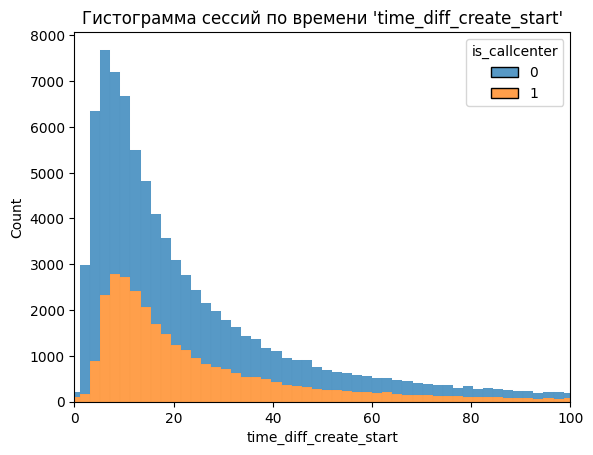

In [39]:
sns.histplot(
    data=df_train_full,
    x='time_diff_create_start',
    hue='is_callcenter',
    bins=10000,
    multiple='stack',
)
plt.xlim(0, 100)
plt.title("Гистограмма сессий по времени 'time_diff_create_start'")
plt.show()

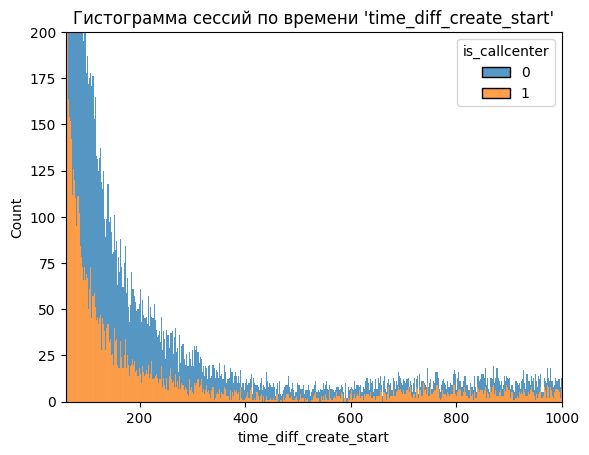

In [41]:
sns.histplot(
    data=df_train_full,
    x='time_diff_create_start',
    hue='is_callcenter',
    bins=10000,
    multiple='stack',
)
plt.xlim(60, 1000)
plt.ylim(0, 200)
plt.title("Гистограмма сессий по времени 'time_diff_create_start'")
plt.show()

<div align="center">

### Пункт 7. Какие идеи не оправдали себя (кратко)

</div>

#### 1) Добавление новых фич, которые ориентированы на перемещение пользователя по страницам - все равно наиболее значимыми оказались фичи сколько раз человек находился на каждого типа странице, суммарное количество посещенных страниц (те фичи, которые были добавлены в самом начале), время пребывания на каждом типе страницы
#### 2) Построение гистограмм для двух таргетных классов по различным исходным фичам, несложных их обработках. Чаще классы все еще оставались неразделимыми визуально, сложно выделить паттерн. Придумавание фичей оказалось очень неинтуитивным - фичи с количеством посещений каждого типа страницы в сессии изначально казались неважными и были добавлены просто чтобы были, а окаалось, что на них держится линейная модель. 
#### 3) Визульное наблюдение за файлами в необработанном виде. Придумать какую-то идею на основании этого очень сложно. 
#### 4) Была идея обнаружить визуально какой-то паттерн поведения пользователей которые звонят и не звонят в коллцентр как последовательность страниц, которые они посещают, при визуальном просмотре датафрейма с сессией и списком страниц - было сложно выделить какие-то закономерности, даже после разделения на группы по количеству просмотенных страниц
#### 5) Разделение на две группы по тому, этот заказ - первый в сессии или не первый в сессии. Количество заказов, которые не первые в сессии - около 10% train. Это разделение и отдельное обучение на двух группах с помощью логрега не дало заметных улучшений по сравнению с теми же фичами + без разбиения на группы. 